# Phase 2: Decision Tree Classifier

from Preprocessing import *;
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split;
from sklearn.preprocessing import LabelEncoder, OneHotEncoder;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report;
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer;
from pandas.api.types import CategoricalDtype
import seaborn as sns
plt.style.use('ggplot')

In [2]:
data = train_df.reset_index(drop=True)

# 1. Feature Selection

Since the listing_id is unique to each lising, it really isn't relevant for our model and will be removed. We will also remove the photos column because we won't be using this in our model either. We will also remove street_address because we can use the display_address as a categorical value since this is just the general street that the listing is on. This helps identify the general neighbourhood the listing is in for the buyer. The description, created, and features columns are removed because these are represented by newly extracted feature columns from the previous milestone.

In [3]:
data.drop(['photos','listing_id','street_address','features','description','created'], axis=1, inplace=True)

## Binarize data by label encoding

In [4]:
cat_type = CategoricalDtype(categories=["high", "medium", "low"],ordered=True)
cat_type

CategoricalDtype(categories=[u'high', u'medium', u'low'], ordered=True)

In [5]:
# high-0, medium-1, low-2
data["interest_level"] = data["interest_level"].astype(cat_type)
data["target"] = data["interest_level"].cat.codes
data.drop(['interest_level'], axis=1, inplace=True)

In [6]:
data["address"] = data["display_address"].astype('category')
data["address"] = data["address"].cat.codes
data.drop(['display_address'], axis=1, inplace=True)

In [7]:
data["building_id"] = data["building_id"].astype('category')
data["building"] = data["building_id"].cat.codes
data.drop(['building_id'], axis=1, inplace=True)

In [8]:
data["manager_id"] = data["manager_id"].astype('category')
data["manager"] = data["manager_id"].cat.codes
data.drop(['manager_id'], axis=1, inplace=True)

## Split our data

I will split our input and target variables into X and y respectively. Next, we will check the distribution of our target variable to see if we must stratify our training and testing data samples.

In [9]:
X = data.drop(['target'], axis=1)
y = data['target']

## Fisher score

Since this is only valid for numerica features, we must first take a subset of our data. We will separate the data based on interest level to calculate the mean and standard deviation of each class. These values will be used to calculate the fisher score for each feature. We can then use a filtering technique to find the most relevant features based on the scores. 

In [10]:
# take subset
numeric = ['bathrooms','bedrooms','latitude','longitude','price','hour_created','address','manager','building']
num_data = data[['bathrooms','bedrooms','latitude','longitude','price','hour_created','address','manager','building','target']]

In [11]:
# separate data by interest level
high = num_data[num_data['target'] == 2].drop(['target'], axis=1)
med = num_data[num_data['target'] == 1].drop(['target'], axis=1)
low = num_data[num_data['target'] == 0].drop(['target'], axis=1)

In [12]:
# calculate mean of each feature in each class
avg_if = np.array([high.mean(),
      med.mean(),
      low.mean()])
#calculate mean of each feature
avg_f = np.array(num_data.drop(['target'], axis=1).mean())

In [13]:
# calculate variance for each feature
var = np.square(np.array([high.std(),
      med.std(),
      low.std()]))

# calculate probability of each class
prob = np.array([high.shape[0]/float(data.shape[0]),
             med.shape[0]/float(data.shape[0]),
             low.shape[0]/float(data.shape[0])]
)

In [14]:
fisher = []
numerator = []
denomerator = []

for feat in np.arange(0,avg_if.shape[1]):
    for class_i in np.arange(0,avg_if.shape[0]):
        numerator.append(np.array(prob[class_i]*np.square(avg_if[class_i][feat]-avg_f[feat])))
        denomerator.append(np.array(prob[class_i]*var[class_i]))      
    fisher.append(np.array(numerator).sum()/np.array(denomerator).sum())
fisher

[1.4391986856950884e-10,
 1.5495308224893388e-10,
 1.0336764419360136e-10,
 7.75380886324851e-11,
 0.0008348517025325086,
 0.000695716318490876,
 0.0011911021471335808,
 0.0010447074295786081,
 0.0019208781511415576]

In [15]:
top3 = ['building', 'manager', 'address']
top5 = ['building', 'manager', 'address','price', 'hour_created']

From the fisher scores, it looks like the building, address, and manager have the top 3 fisher scores, in that order.  Price and hour the listing was created also have decent fisher scores. The worst was longitude and the rest weren't that far off either with 10 significant digits. 

# 2. Train Classifiers

## First Version

The classifier doesn't accept the extracted text features from the previous milestone so for the first classifier they were removed and the classifier was trained for the numerical data only. The 3 features with the highest fisher scores are selected for the first classifier. These are price, hour created, and bedrooms. The default Gini index was used to determine the best split for each node. The classifier predicted with average 63.32% accuracy.

In [16]:
# perform cross-validation for first set of classifiers
kf = KFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[top3]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[top3])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6341463414634146,
 0.6279471544715447,
 0.6371582477894094,
 0.6363451570281533,
 0.6324829759121862]

In [17]:
np.array(acc_scores).mean()

0.6336159753329417

In [18]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

         low       0.23      0.26      0.24       781
      medium       0.36      0.38      0.37      2267
        high       0.79      0.76      0.77      6791

   micro avg       0.63      0.63      0.63      9839
   macro avg       0.46      0.47      0.46      9839
weighted avg       0.64      0.63      0.64      9839



## Second Version

Top 5 features according to Fisher scores were used for this classifier. Gini index was used to determine the best split for each node. The classifier predicted with the same average accuracy (63.32%) as the first version.

In [19]:
# perform cross-validation for first set of classifiers
kf = KFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[top5]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[top5])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6330284552845529,
 0.6270325203252033,
 0.6285191584510621,
 0.6381746112409797,
 0.6302469763187316]

In [20]:
np.array(acc_scores).mean()

0.631400344324106

In [21]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

         low       0.27      0.30      0.28       781
      medium       0.34      0.34      0.34      2267
        high       0.78      0.77      0.77      6791

   micro avg       0.63      0.63      0.63      9839
   macro avg       0.46      0.47      0.46      9839
weighted avg       0.64      0.63      0.63      9839



## Third Version

All numeric features were used for this classifier. The default Gini index was used to determine the best split for each node like before. The classifier predicted with average 65.66% accuracy. It looks like the classifier has slightly better accuracy with all features.

In [22]:
# perform cross-validation for first set of classifiers
kf = KFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6579268292682927,
 0.6576219512195122,
 0.6517938814920216,
 0.6518955178371786,
 0.6563675170240878]

In [23]:
np.array(acc_scores).mean()

0.6551211393682186

In [24]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

         low       0.30      0.33      0.32       781
      medium       0.38      0.39      0.39      2267
        high       0.80      0.78      0.79      6791

   micro avg       0.66      0.66      0.66      9839
   macro avg       0.49      0.50      0.50      9839
weighted avg       0.66      0.66      0.66      9839



## Fourth Version

We can check the distribution of the target to see if stratifying the samples will help us identify any under-represented classes.

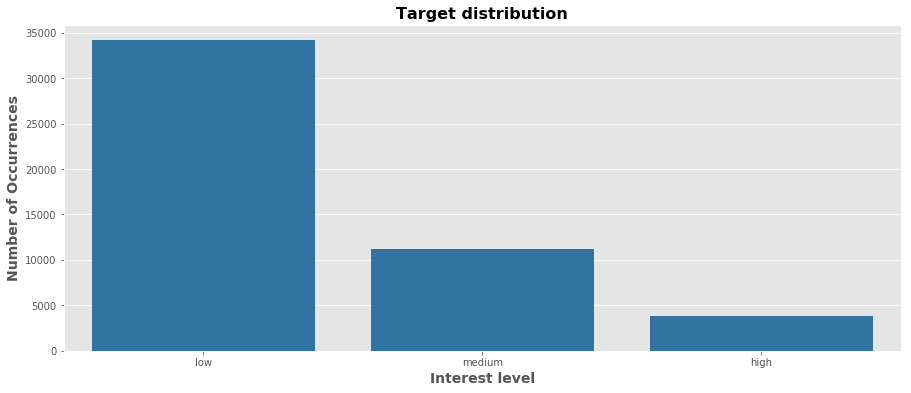

In [25]:
int_level = train_df['interest_level'].value_counts()
plt.figure(figsize=(15,6))
sns.barplot(int_level.index, int_level.values, alpha=1, order=['low','medium','high'],color=color[0])
plt.ylabel('Number of Occurrences', fontsize=14, fontweight='bold')
plt.xlabel('Interest level', fontsize=14, fontweight='bold')
plt.title('Target distribution', fontsize=16, fontweight='bold')
plt.show()

Since the distribution of our target is skewed, we should stratify our data when spliting so it represents our data well. All numeric features were used for this classifier. Gini index was used to determine the best split for each node. A stratified k-fold cross validation method was used. The classifier predicted with average 65.74% accuracy, which is ever so slightly better than regular k-fold cross validation.

In [26]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X, y):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6536585365853659,
 0.65630081300813,
 0.6578252032520325,
 0.6506758816952942,
 0.659890221589754]

In [27]:
np.array(acc_scores).mean()

0.6556701312261153

In [28]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

         low       0.32      0.35      0.34       763
      medium       0.37      0.39      0.38      2239
        high       0.80      0.78      0.79      6836

   micro avg       0.66      0.66      0.66      9838
   macro avg       0.50      0.51      0.50      9838
weighted avg       0.67      0.66      0.66      9838



## Fifth Version

All numeric features were used for this classifier. Entropy was used to determine the best split for each node. A stratified k-fold cross validation method was used. The classifier predicted with average 65.62% accuracy, which is ever so slightly worse than using gini index to find the best split.

In [29]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X, y):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6553861788617886,
 0.6532520325203252,
 0.6630081300813008,
 0.6530135176339059,
 0.6511486074405367]

In [30]:
np.array(acc_scores).mean()

0.6551616933075715

In [31]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

         low       0.32      0.35      0.34       763
      medium       0.35      0.36      0.36      2239
        high       0.79      0.78      0.79      6836

   micro avg       0.65      0.65      0.65      9838
   macro avg       0.49      0.50      0.49      9838
weighted avg       0.66      0.65      0.65      9838



## Sixth Version

All numeric features were used for this classifier. Gini index was used to determine the best split for each node since it performed slightly better. A stratified k-fold cross validation method was used. Minimum support was changed to 3 to combat overfitting. The classifier predicted with average 66.46% accuracy.

In [32]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X, y):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0,min_samples_leaf=3)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6525406504065041,
 0.6616869918699188,
 0.6590447154471545,
 0.6619575160077243,
 0.655621061191299]

In [33]:
np.array(acc_scores).mean()

0.6581701869845202

In [34]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

         low       0.32      0.36      0.34       763
      medium       0.36      0.38      0.37      2239
        high       0.80      0.78      0.79      6836

   micro avg       0.66      0.66      0.66      9838
   macro avg       0.49      0.50      0.50      9838
weighted avg       0.66      0.66      0.66      9838



## Hot encode features vector

The Decision Tree classifier in the sklearn sorts each feature to split the data and doesn't support features that are vectors. So to use any text features we must hot encode them. However, the description vectors are 1119 long so we will only do the features. Looking at the two text features, it seems like description might not be that helpful because there are a lot of irrelevant words/strings in most of them like 'XXX'.  

In [35]:
feat = data['feat_vect'].apply(lambda x: x.toarray().tolist())
feat_list = []
for i in feat:
    feat_list.append(i)

In [36]:
X2 = pd.DataFrame(np.array(feat_list).reshape(np.array(feat_list).shape[0],np.array(feat_list).shape[2]))
X2 = X[numeric].join(X2)

## Seventh Version

All numeric features and the hot encoded features were used for this classifier. Gini was used to determine the best split for each node. A stratified k-fold cross validation method was used. Minimum support was changed to 3 to combat overfitting. The classifier predicted with average 66.67% accuracy, which is slightly better than the previous. Looking at the tfidf vectors of the features column, it looks like each one only has one value out of the 79 word dictionary. The features of most listing must be very similar or have very rare words.

In [37]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X2, y):
    # split data
    X_train, X_valid = X2.iloc[train_index], X2.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0,min_samples_leaf=3)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid)
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6539634146341463,
 0.6600609756097561,
 0.6626016260162602,
 0.6632787884947657,
 0.6591786948566782]

In [38]:
np.array(acc_scores).mean()

0.6598166999223213

In [39]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

         low       0.33      0.37      0.35       763
      medium       0.37      0.40      0.38      2239
        high       0.81      0.78      0.79      6836

   micro avg       0.66      0.66      0.66      9838
   macro avg       0.50      0.52      0.51      9838
weighted avg       0.67      0.66      0.66      9838



## Seventh Version

All numeric features and the features were used for this classifier. Gini index seemed to do slightly better so it was used to determine the best split for each node. A stratified k-fold cross validation method was used. Minimum support was changed to 100 and the classifier predicted with average 71.21% accuracy, which is an improvement. Recall and f1-score for medium interest class was at an all time high with 0.92 and 0.83 respectively. Precision seemed to improve for all classes by 0.17 for low and 0.06 for high. 

In [40]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
best_acc = 0
for train_index, valid_index in kf.split(X2, y):
    # split data
    X_train, X_valid = X2.iloc[train_index], X2.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0,min_samples_leaf=100)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_clf = clf
acc_scores

[0.7078252032520326,
 0.7138211382113822,
 0.714329268292683,
 0.7145035064539079,
 0.7076641593819882]

In [41]:
np.array(acc_scores).mean()

0.7116286551183988

In [42]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

         low       0.48      0.14      0.22       763
      medium       0.42      0.28      0.33      2239
        high       0.77      0.91      0.83      6836

   micro avg       0.71      0.71      0.71      9838
   macro avg       0.56      0.44      0.46      9838
weighted avg       0.67      0.71      0.67      9838



# 3. Testing

## Processing test dataset

In [44]:
test = pd.read_json("test.json")
test = test.reset_index(drop=True)

In [45]:
# convert column to datetime
test["created"] = pd.to_datetime(test["created"])
# add hour created column
test["hour_created"] = test["created"].dt.hour

In [46]:
# label encode
test["address"] = test["display_address"].astype('category')
test["address"] = test["address"].cat.codes
test["manager_id"] = test["manager_id"].astype('category')
test["manager"] = test["manager_id"].cat.codes
test.drop(['manager_id'], axis=1, inplace=True)
test["building_id"] = test["building_id"].astype('category')
test["building"] = test["building_id"].cat.codes
test.drop(['building_id'], axis=1, inplace=True)

In [47]:
# convert features list to string
test['features'] = test['features'].apply(lambda x: ' '.join(x))

In [48]:
# extract features using tfidf
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', token_pattern=r'^[a-zA-Z][a-zA-Z]+',max_features=79)
vectorizer.fit(test['features'].values);
test['feat_vect'] = test['features'].apply(lambda x: vectorizer.transform([x]))

In [49]:
# convert features vectors to list
feat = test['feat_vect'].apply(lambda x: x.toarray().tolist())
feat_list = []
for i in feat:
    feat_list.append(i)

In [50]:
# create dataframe of hot encoded feature vector
test2 = pd.DataFrame(np.array(feat_list).reshape(np.array(feat_list).shape[0],np.array(feat_list).shape[2]))

In [51]:
# join hot encoded features to test dataset
test = test.join(test2)

In [52]:
test.drop(['photos','street_address','features','description','created','display_address','feat_vect'], axis=1, inplace=True)
test

,bathrooms,bedrooms,latitude,listing_id,longitude,price,hour_created,address,manager,building,...,69,70,71,72,73,74,75,76,77,78
0,1.0,1,40.7185,7142618,-73.9865,2950,5,9506,2694,4412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,40.7278,7210040,-74.0000,2850,6,9589,3145,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1,40.7306,7103890,-73.9890,3758,4,660,2346,2257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2,40.7109,7143442,-73.9571,3300,6,318,179,4368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,2,40.7650,6860601,-73.9845,4900,5,8767,2764,3530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,3,40.7901,6840081,-73.9774,9000,6,10826,2259,5678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,2,40.7730,6922337,-73.9571,2800,3,7117,1205,4676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0,40.6751,6913616,-73.9511,1900,6,9283,198,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,2,40.7597,6937820,-73.9929,3000,5,11128,3467,2338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0,40.7208,6893933,-73.9887,2300,3,9009,381,4516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Predictions on  test dataset

Score (multiclass log-loss) = 1.09861

In [75]:
# use best classifier on test dataset
y_pred = best_clf.predict_proba(test.drop(['listing_id'],axis=1))

In [76]:
listing_id = test['listing_id'].values
listing_id = listing_id.reshape(listing_id.shape[0],1)

In [77]:
# Test output for log loss
test_prob = np.concatenate((listing_id,y_pred),axis=1)
np.savetxt('test.csv',test_prob, delimiter=',',header='listing_id,high,medium,low')